In [1]:
import os
import sys
import gc
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
tqdm_notebook().pandas()

/tmp/ipykernel_16632/1343480259.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

64.1% compressed
69.1% compressed
81.2% compressed
73.5% compressed
70.8% compressed


## EDA

In [4]:
item_agg = train.groupby(by='item_id').agg({
    'item_price':['count', 'mean', 'std'],
    'item_category_id':'nunique',
    'shop_id': 'nunique'
})
item_agg.columns = ['_'.join(column) for column in item_agg.columns]
item_agg = item_agg.reset_index()

<AxesSubplot:xlabel='item_price_std', ylabel='Count'>

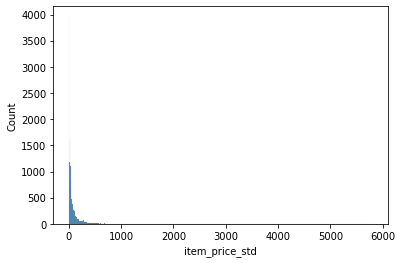

In [5]:
sns.histplot(item_agg['item_price_std'])

In [6]:
sum(item_agg['item_category_id_nunique'] > 1)

0

In [7]:
item_agg[item_agg['item_price_std']>500]

,item_id,item_price_count,item_price_mean,item_price_std,item_category_id_nunique,shop_id_nunique
27,27,42,1461.228516,609.841595,1,27
29,29,14,1759.285767,612.603954,1,11
39,39,7,5813.285645,536.745040,1,7
102,103,2,13900.000000,1414.213562,1,1
462,475,18,29200.000000,3925.332507,1,2
...,...,...,...,...,...,...
20496,20835,2,14249.500000,1059.953065,1,2
20503,20846,7,4677.571289,1274.054271,1,4
21003,21353,77,5636.142578,742.552475,1,31
21076,21428,78,1983.525635,513.607656,1,29


In [8]:
num_item_in_test = len(test['item_id'].unique())
num_item_not_in_train = len(set(test['item_id']).difference(set(train['item_id'].unique())))
num_item_in_test, num_item_not_in_train, num_item_not_in_train/num_item_in_test

(5100, 363, 0.0711764705882353)

In [9]:
num_shop_in_test = len(test['shop_id'].unique())
num_shop_not_in_train = len(set(test['shop_id']).difference(set(train['shop_id'].unique())))
num_shop_in_test, num_shop_not_in_train, num_shop_not_in_train/num_shop_in_test

(42, 0, 0.0)

### Notes
- all shops in test set exist in train set
- ~7% of items in test set but no in train set

In [10]:
train[train['item_cnt_day'] <= 0]['item_cnt_day'].value_counts()

-1     7252
-2       78
-3       14
-5        4
-4        3
-6        2
-22       1
-16       1
-9        1
Name: item_cnt_day, dtype: int64

In [11]:
train[train['item_cnt_day'] <= 0].shape[0]/train.shape[0]

0.0025055784544777337

### Notes
It's weird that number of sold is negative, 0.2% of data have nagative sold. Try to handle in some methods:
- ignore negative value, remove from train set
- maybe it is number of return
    - treat as normal sold
    - create new feature for number of return 

In [12]:
def get_month(x):
    arr_tokens = x.split('.')
    month = int(arr_tokens[2] + arr_tokens[1])
    return month

train['month'] = train['date'].apply(get_month)

agg_dict = {
    'item_price': ['mean'],
    'item_cnt_day': ['sum', 'count']
}

month_data = train.groupby(by=['month', 'shop_id', 'item_id']).agg(agg_dict)
month_data.columns = ['_'.join(col) for col in month_data.columns]
month_data = month_data.reset_index()
month_data = month_data.rename(columns={
    'item_cnt_day_sum': 'item_cnt_month',
    'item_cnt_day_count': 'sold_date_count'
})
month_data = month_data.sort_values(by=['shop_id', 'month'], ascending=True)
month_data = month_data.merge(items, how='left', on='item_id')
month_data['revenue'] = month_data['item_cnt_month'] * month_data['item_price_mean']

In [13]:
month_data['month'].unique(), len(month_data['month'].unique())

(array([201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308,
        201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404,
        201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412,
        201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508,
        201509, 201510]),
 34)

In [14]:
month_data['shop_id'].unique(), len(month_data['shop_id'].unique())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 60)

### Extract feature

In [15]:
# Extract data with a item_price greater than 0
train = train[train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
train = train[train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
train = train[train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
train = train[train['item_cnt_day'] < 1000]

#### Shop month feature

In [16]:
shop_month_data = month_data.groupby(by=['shop_id', 'month']).agg({
    'item_id': ['nunique'],
    'item_category_id': ['nunique'],
    'revenue': ['sum'],
    'item_cnt_month': ['sum', 'mean', 'std'],
    'sold_date_count': ['sum', 'std']
})

shop_month_data.columns = ['shop_' + '_'.join(col) for col in shop_month_data.columns]
shop_month_data = shop_month_data.reset_index()

In [17]:
shop_month_data.columns

Index(['shop_id', 'month', 'shop_item_id_nunique',
       'shop_item_category_id_nunique', 'shop_revenue_sum',
       'shop_item_cnt_month_sum', 'shop_item_cnt_month_mean',
       'shop_item_cnt_month_std', 'shop_sold_date_count_sum',
       'shop_sold_date_count_std'],
      dtype='object')

In [18]:
len(shop_month_data['shop_id'].unique()) * len(shop_month_data['month'].unique())

2040

In [19]:
list_shop_ids = list(shop_month_data['shop_id'].unique())
list_month = list(shop_month_data['month'].unique())
shop_month_combination = list(itertools.product(*[list_shop_ids, list_month]))

full_shop_month_data = pd.DataFrame(shop_month_combination)
full_shop_month_data.columns = ['shop_id', 'month']

del(list_shop_ids, list_month, shop_month_combination)
gc.collect()

80

In [20]:
full_shop_month_data = full_shop_month_data.merge(shop_month_data, how='left', on=['shop_id', 'month'])
full_shop_month_data = full_shop_month_data.sort_values(by=['shop_id', 'month'], ascending=True)
full_shop_month_data['shop_revenue_sum'] = full_shop_month_data['shop_revenue_sum'].fillna(0)

del(shop_month_data)
gc.collect()

0

In [21]:
full_shop_month_data['shop_revenue_sum_3_month'] = full_shop_month_data.groupby(by='shop_id')['shop_revenue_sum'].progress_apply(lambda x: 
         x        
        .rolling(window=3, min_periods=3)
        .agg('sum')
)

full_shop_month_data['shop_revenue_sum_6_month'] = full_shop_month_data.groupby(by='shop_id')['shop_revenue_sum'].progress_apply(lambda x: 
         x        
        .rolling(window=6, min_periods=6)
        .agg('sum')
)
full_shop_month_data['shop_revenue_sum_12_month'] = full_shop_month_data.groupby(by='shop_id')['shop_revenue_sum'].progress_apply(lambda x: 
         x        
        .rolling(window=12, min_periods=12)
        .agg('sum')
)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [22]:
full_shop_month_data

,shop_id,month,shop_item_id_nunique,shop_item_category_id_nunique,shop_revenue_sum,shop_item_cnt_month_sum,shop_item_cnt_month_mean,shop_item_cnt_month_std,shop_sold_date_count_sum,shop_sold_date_count_std,shop_revenue_sum_3_month,shop_revenue_sum_6_month,shop_revenue_sum_12_month
0,0,201301,2385.0,45.0,2.966061e+06,5578.0,2.338784,3.440424,4793.0,2.158056,NaN,NaN,NaN
1,0,201302,2436.0,48.0,3.670881e+06,6127.0,2.515189,4.210208,5064.0,2.303187,NaN,NaN,NaN
2,0,201303,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,6.636942e+06,NaN,NaN
3,0,201304,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.670881e+06,NaN,NaN
4,0,201305,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,59,201506,543.0,43.0,8.635125e+05,913.0,1.681400,2.017398,836.0,1.341158,2.938025e+06,6.459744e+06,1.641034e+07
2036,59,201507,591.0,41.0,8.591119e+05,992.0,1.678511,2.013058,916.0,1.336754,2.748046e+06,5.976850e+06,1.635914e+07
2037,59,201508,593.0,44.0,1.022714e+06,1214.0,2.047218,4.787138,973.0,1.531478,2.745338e+06,5.836747e+06,1.618741e+07
2038,59,201509,491.0,42.0,1.103781e+06,914.0,1.861507,2.276133,778.0,1.393309,2.985607e+06,5.923632e+06,1.571920e+07


In [23]:
full_shop_month_data = downcast(full_shop_month_data)

47.2% compressed


#### Item month feature

In [24]:
item_month_data = month_data.groupby(by=['item_id', 'month']).agg({
    'shop_id': ['nunique'],
    'revenue': ['sum'],
    'item_cnt_month': ['sum', 'mean', 'std'],
    'sold_date_count': ['sum', 'std']
})

item_month_data.columns = ['item_' + '_'.join(col) for col in item_month_data.columns]
item_month_data = item_month_data.reset_index()

In [25]:
item_month_data = downcast(item_month_data)

56.5% compressed


#### Category month feature

In [26]:
category_month_data = month_data.groupby(by=['item_category_id', 'month']).agg({
    'shop_id': ['nunique'],
    'item_id': ['nunique'],    
    'revenue': ['sum'],
    'item_cnt_month': ['sum', 'mean', 'std'],
    'sold_date_count': ['sum', 'std']
})

category_month_data.columns = ['category_' + '_'.join(col) for col in category_month_data.columns]
category_month_data = category_month_data.reset_index()

In [27]:
category_month_data = downcast(category_month_data)

60.5% compressed


#### item shop month feature

In [28]:
list_shop_ids = list(month_data['shop_id'].unique())
list_item_ids = list(month_data['item_id'].unique())
list_month = list(month_data['month'].unique())
shop_item_month_combination = list(itertools.product(*[list_shop_ids, list_item_ids, list_month]))
full_shop_item_month_data = pd.DataFrame(shop_item_month_combination)
full_shop_item_month_data.columns = ['shop_id', 'item_id', 'month']


full_shop_item_month_data = full_shop_item_month_data.merge(month_data, how='left', on=['shop_id', 'item_id', 'month'])
full_shop_item_month_data['sold_date_count'] = full_shop_item_month_data['sold_date_count'].fillna(0)
full_shop_item_month_data['item_cnt_month'] = full_shop_item_month_data['item_cnt_month'].fillna(0)
full_shop_item_month_data['item_cnt_month'] = full_shop_item_month_data['item_cnt_month'].astype(int)


full_shop_item_month_data = downcast(full_shop_item_month_data)
del(list_shop_ids, list_item_ids, list_month, shop_item_month_combination)
# del(month_data)
gc.collect()

53.1% compressed


13

In [29]:
full_shop_item_month_data['item_cnt_sum_3_month'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].progress_apply(lambda x: 
         x        
        .rolling(window=3, min_periods=3)
        .agg('sum')
)

# full_shop_item_month_data['item_cnt_sum_6_month'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].progress_apply(lambda x: 
#          x        
#         .rolling(window=6, min_periods=6)
#         .agg('sum')
# )

# full_shop_item_month_data['item_cnt_sum_12_month'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].progress_apply(lambda x: 
#          x        
#         .rolling(window=12, min_periods=12)
#         .agg('sum')
# )

  0%|          | 0/1308420 [00:00<?, ?it/s]

In [30]:
full_shop_item_month_data['item_cnt_month_lag_2'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].shift(1)
full_shop_item_month_data['item_cnt_month_lag_3'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].shift(2)
full_shop_item_month_data['item_cnt_month_lag_12'] = full_shop_item_month_data.groupby(by=['shop_id', 'item_id'])['item_cnt_month'].shift(12)

In [31]:
full_shop_item_month_data = downcast(full_shop_item_month_data)

25.8% compressed


In [32]:
sys.getsizeof(full_shop_item_month_data)/2**30

1.9058295488357544

### prepare train data

In [33]:
def prev_month(month_year):
    year = month_year//100
    month = month_year%100
    if month == 1:
        month = 12
        year -= 1
    prev_month = year * 100 + month
    return prev_month

train_data = month_data[['month', 'shop_id', 'item_id', 'item_cnt_month']].copy()
train_data = train_data.rename(columns={'month': 'current_month', 'item_cnt_month': 'month_sale'})

In [34]:
list_months = list(train_data['current_month'].unique())
list_shop_ids = list(train_data['shop_id'].unique())
list_item_ids = list(train_data['item_id'].unique())

total_combination = len(list_months) * len(list_shop_ids) * len(list_item_ids)
train_data.shape[0]/total_combination

0.03617124200989608

In [35]:
have_sale_combination = []
for x in train_data[['current_month', 'shop_id', 'item_id']].values:
    have_sale_combination.append(tuple(x))

have_sale_combination = set(have_sale_combination)

all_combination = list(itertools.product(*[list_months, list_shop_ids, list_item_ids]))
all_combination = set(all_combination)
no_sale_combination = all_combination.difference(have_sale_combination)

In [36]:
no_sale_df = pd.DataFrame(no_sale_combination)
no_sale_df.columns = ['current_month', 'shop_id', 'item_id']
no_sale_df['month_sale'] = 0

no_sale_df = no_sale_df.sample(frac=0.1)

In [37]:
full_train_data = pd.concat([train_data, no_sale_df])
full_train_data = downcast(full_train_data)

del(no_sale_df, month_data)
gc.collect()

57.5% compressed


18

In [38]:
full_train_data['prev_month'] = full_train_data['current_month'].apply(prev_month)
full_train_data['month_of_year'] = full_train_data['current_month'].apply(lambda x: x%100)

In [39]:
full_train_data = full_train_data.merge(items, how='left', on='item_id')
full_train_data = downcast(full_train_data)

32.4% compressed


In [40]:
def merge_feature(df):
    df = df.merge(full_shop_month_data, how='left', left_on=['shop_id', 'prev_month'], right_on=['shop_id', 'month'])
    df = df.merge(item_month_data, how='left', left_on=['item_id', 'prev_month'], right_on=['item_id', 'month'])
    df = df.merge(category_month_data, how='left', left_on=['item_category_id', 'prev_month'], right_on=['item_category_id', 'month'])
    df = df.drop(columns='item_category_id')    
    df = df.merge(full_shop_item_month_data, how='left', left_on=['shop_id', 'item_id', 'prev_month'], right_on=['shop_id', 'item_id', 'month'])
    return df

full_train_data = merge_feature(full_train_data)

/media/phucdk/data/Project/python38_vf/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'month_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [41]:
# full_train_data = downcast(full_train_data)

In [42]:
full_train_data.columns

Index(['current_month', 'shop_id', 'item_id', 'month_sale', 'prev_month',
       'month_of_year', 'month_x', 'shop_item_id_nunique',
       'shop_item_category_id_nunique', 'shop_revenue_sum',
       'shop_item_cnt_month_sum', 'shop_item_cnt_month_mean',
       'shop_item_cnt_month_std', 'shop_sold_date_count_sum',
       'shop_sold_date_count_std', 'shop_revenue_sum_3_month',
       'shop_revenue_sum_6_month', 'shop_revenue_sum_12_month', 'month_y',
       'item_shop_id_nunique', 'item_revenue_sum', 'item_item_cnt_month_sum',
       'item_item_cnt_month_mean', 'item_item_cnt_month_std',
       'item_sold_date_count_sum', 'item_sold_date_count_std', 'month_x',
       'category_shop_id_nunique', 'category_item_id_nunique',
       'category_revenue_sum', 'category_item_cnt_month_sum',
       'category_item_cnt_month_mean', 'category_item_cnt_month_std',
       'category_sold_date_count_sum', 'category_sold_date_count_std',
       'month_y', 'item_price_mean', 'item_cnt_month', 'sold_date

In [43]:
full_train_data.head(5)

,current_month,shop_id,item_id,month_sale,prev_month,month_of_year,month_x,shop_item_id_nunique,shop_item_category_id_nunique,shop_revenue_sum,...,month_y,item_price_mean,item_cnt_month,sold_date_count,item_category_id,revenue,item_cnt_sum_3_month,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_12
0,201301,0,32,6,201212,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201301,0,33,3,201212,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201301,0,35,1,201212,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201301,0,43,1,201212,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201301,0,51,2,201212,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
train_columns = [
    #'current_month', 
#                  'shop_id', 
    'item_id', 
    'item_category_id',
    'item_cnt_month',
    'item_cnt_sum_3_month',
    'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 
#     'item_cnt_month_lag_12',
    'shop_revenue_sum_3_month',
       'shop_revenue_sum_6_month', 'shop_revenue_sum_12_month',
                'item_price_mean', 'sold_date_count', 'revenue',
#                 'prev_month', 
    'shop_item_id_nunique',
                'shop_item_category_id_nunique', 'shop_revenue_sum',
                'shop_item_cnt_month_sum', 'shop_item_cnt_month_mean',
                'shop_item_cnt_month_std', 'shop_sold_date_count_sum',
                'shop_sold_date_count_std', 'item_shop_id_nunique',
                'item_revenue_sum', 'item_item_cnt_month_sum',
                'item_item_cnt_month_mean', 'item_item_cnt_month_std',
                'item_sold_date_count_sum', 'item_sold_date_count_std',
                'category_shop_id_nunique', 'category_item_id_nunique',
                'category_revenue_sum', 'category_item_cnt_month_sum',
                'category_item_cnt_month_mean', 'category_item_cnt_month_std',
                'category_sold_date_count_sum', 'category_sold_date_count_std',
                'month_of_year']
categorical_features = ['month_of_year', 'item_category_id', 'item_id']
len(train_columns)

36

In [45]:
train_data.columns

Index(['current_month', 'shop_id', 'item_id', 'month_sale'], dtype='object')

In [46]:
full_train_data.shape

(5896840, 45)

In [47]:
# val_size = 250000
# test_size = 250000
# test_set = train_data[-test_size:]
# val_set = train_data[-(val_size + test_size): -test_size]
# train_set = train_data[:-(val_size + test_size)]


# X_train = train_set[train_columns]
# X_val = val_set[train_columns]
# X_test = test_set[train_columns]
# y_train = train_set['item_cnt_month']
# y_val = val_set['item_cnt_month']
# y_test = test_set['item_cnt_month']

In [48]:
X_all = full_train_data[train_columns]
y_all = full_train_data['month_sale']

X_train, X_val_test, y_train, y_val_test = train_test_split(X_all, y_all, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

### lgbm model

In [49]:
## lgbm param
params = {'boosting': 'gbdt',
          'metric': 'rmse',
          'objective': 'regression',
          'num_leaves': 256,
          'max_depth': 12,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 200,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17
          }

early_stop = 200
verbose_eval = 50
num_rounds = 500

In [50]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_val, label=y_val)
watchlist = [d_train, d_valid]

model = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=num_rounds,
                  valid_sets=watchlist,
                  verbose_eval=verbose_eval,
                  early_stopping_rounds=early_stop,
                  categorical_feature=categorical_features)

/media/phucdk/data/Project/python38_vf/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/media/phucdk/data/Project/python38_vf/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'item_id', 'month_of_year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/media/phucdk/data/Project/python38_vf/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and 

Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 3.48286	valid_1's rmse: 2.96123
[100]	training's rmse: 2.83084	valid_1's rmse: 2.21887
[150]	training's rmse: 2.5339	valid_1's rmse: 1.86616
[200]	training's rmse: 2.40528	valid_1's rmse: 1.71499
[250]	training's rmse: 2.34754	valid_1's rmse: 1.65691
[300]	training's rmse: 2.31816	valid_1's rmse: 1.63178
[350]	training's rmse: 2.30155	valid_1's rmse: 1.61926
[400]	training's rmse: 2.29104	valid_1's rmse: 1.61311
[450]	training's rmse: 2.25888	valid_1's rmse: 1.58444
[500]	training's rmse: 2.23337	valid_1's rmse: 1.56744
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 2.23337	valid_1's rmse: 1.56744


In [51]:
y_test_pred = model.predict(X_test)
np.sqrt(np.mean(np.square(y_test_pred - y_test)))

1.820601087863184

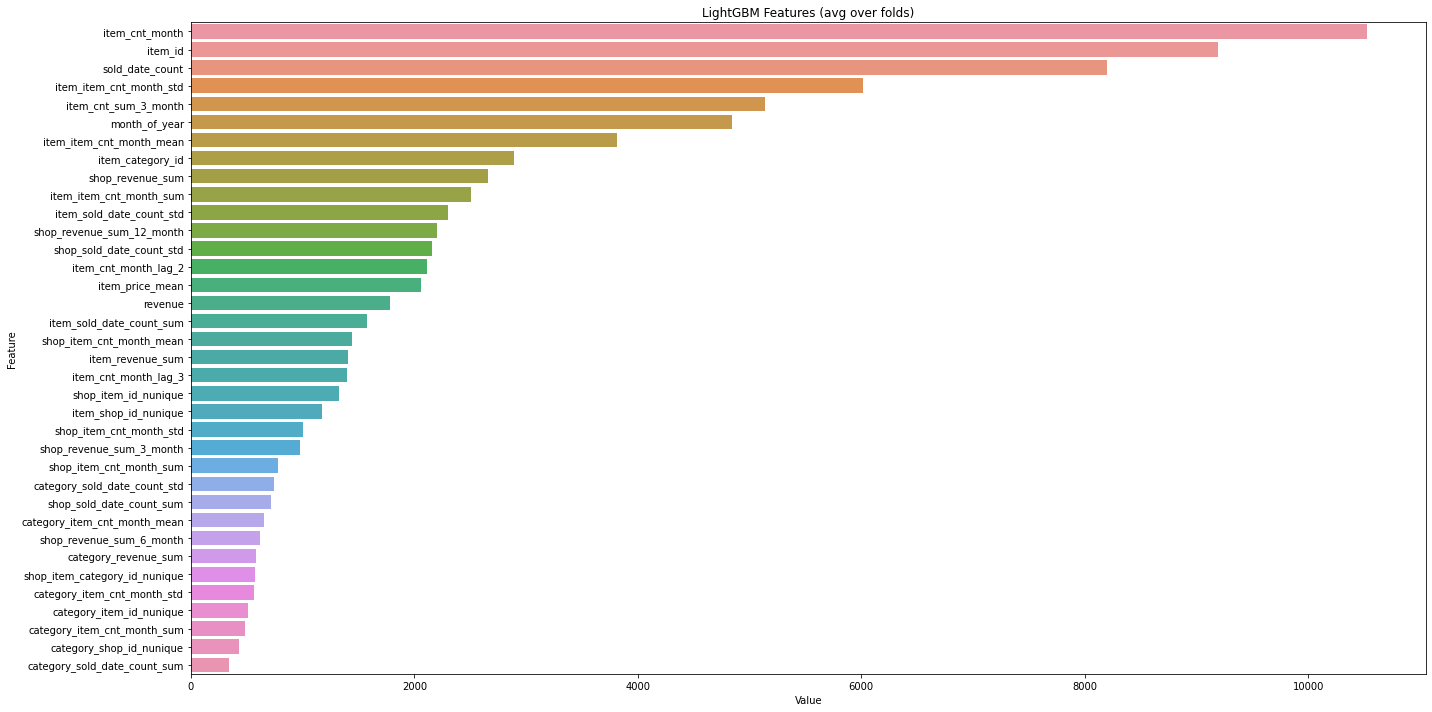

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

### prediction

In [53]:
del(full_train_data)
gc.collect()

9626

In [54]:
test = pd.read_csv('test.csv')

In [55]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [56]:
test = test.merge(items, how='left', on='item_id')
test['prev_month'] = 201510
test['month_of_year'] = 11

In [57]:
test = merge_feature(test)

In [58]:
y_pred = model.predict(test[train_columns])

In [59]:
test['item_cnt_month'] = y_pred
test[['ID', 'item_cnt_month']].to_csv('sample_submission.csv', index=False)

In [60]:
y_pred

array([0.00288682, 0.3163686 , 1.00212931, ..., 0.00389384, 0.00364032,
       0.00376169])

In [76]:
item_predict_result = dict()
for index, row  in test[['item_id', 'shop_id', 'item_cnt_month']].iterrows():
    item_id = int(row['item_id'])
    shop_id = int(row['shop_id'])
    predict_sale = row['item_cnt_month']
    if item_id not in item_predict_result:
        item_predict_result[item_id] = []
    item_predict_result[item_id].append((shop_id, predict_sale))

In [77]:
import pickle

In [78]:
pickle.dump(item_predict_result, open('item_predict_result.pkl', 'wb'))